<a href="https://colab.research.google.com/github/PaolaGAPI/Analyze-audio-signals-to-determine-the-music-Genre/blob/main/CNN_for_Music_Genre_Classification_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Model for Music Genre Classification:

Una red neuronal convolucional (ConvNet/CNN) es un algoritmo de aprendizaje profundo que puede tomar una imagen de entrada, asignar importancia (pesos) a varias características en la imagen y poder diferenciar una de otra. CNN trabaja con convolución y agrupación en secuencia alterna en la red neuronal. Entonces, ¿por qué usar CNN en la clasificación de géneros? CNN, como se discutió antes, está especializado en el reconocimiento de características de imagen, asi pues como mencionamos anteriormente el espectrograma que representa el MFCC junto con el tiempo y la frecuencia será la entrada del modelo CNN.


En primer lugar, importamos algunas bibliotecas necesarias. Librosa es un paquete útil para manejar archivos de audio en Python, ya que proporciona no solo E/S, sino también varias transformaciones y extracción de características de audio, incluido MFCC.

librerias usadas:

librosa, librosa.display
matplotlib
numpy
os
math
json


In [91]:
!pip install librosa
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install scipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import random
import librosa
import math
import matplotlib


## The Dataset - GTZAN

- Instancias (m): 1.000
- Duración de la secuencia (por instancia): 30 segundos
- Etiquetas: 10 (Blues, Clásica, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparación del conjunto de datos.

### Pasos
1. Crea el conjunto de datos
2. Ajuste la CNN al conjunto de datos
3. Evaluar el desempeño

### Creando el conjunto de datos
Según los diferentes recursos que encuentro en línea (Kaggle y algunas publicaciones de blog), parece que el camino a seguir es extraer características significativas de los datos, darles forma para que compartan dimensiones y construir un tensor a partir de ellos.
La característica más interesante fue el Mel-Spectogram
  

## 1. Setup, Data, Feature Engineering

# Loading Datasets:

In [93]:
DATASET_PATH = "/content/drive/MyDrive/Universidad/AI/Final Project/Data/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # diccionario para almacenar mapas, etiquetas y MFCC
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # recorrer todas las subcarpetas de género
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # asegurarnos de que estamos procesando un nivel de subcarpeta de género
        if dirpath is not dataset_path:

            # guardar la etiqueta de género (es decir, el nombre de la subcarpeta) en la asignación
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # procesar todos los archivos de audio en el subdirectorio de género
            for f in filenames:

		# cargar archivo de audio
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # procesar todos los segmentos del archivo de audio
                for d in range(num_segments):

                    # calcular la muestra de inicio y fin para el segmento actual
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                   # extraer mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # almacenar solo la función mfcc con el número esperado de vectores
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

   # guardar MFCC en un archivo json
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

El proceso de creacion del archivo toma mas de 3 minutos, asi que para no crear tanta demora en correr este archivo, lo tenemos ya hecho, el archivo .json contiene con datos numericos de las canciones de la base de datos de GTZAN para poder crear el MCFF.

In [95]:
# ruta a json
DATA_PATH = "/content/data_10.json"

convertimos las listas en matrices numpy con los datos de las canciones.

In [96]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convertir listas en matrices numpy
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [97]:
# Cargar datos
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [98]:
# crear entreno, validación y división de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# agregar un eje a los conjuntos de entrada
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [99]:
X_train.shape


(5991, 130, 13, 1)

In [100]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [101]:
# construimos la CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# aplanar la salida y alimentarla en una capa densa
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# capa de salida
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [102]:
# compilar modelo
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [104]:
# Entrenar el modelo con epochs = 50
# history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 15s 76ms/step - loss: 2.3281 - accuracy: 0.2430 - val_loss: 1.8183 - val_accuracy: 0.3591
Epoch 2/50
188/188 [==============================] - 17s 93ms/step - loss: 1.8324 - accuracy: 0.3732 - val_loss: 1.5332 - val_accuracy: 0.4453
Epoch 3/50
188/188 [==============================] - 14s 72ms/step - loss: 1.6331 - accuracy: 0.4330 - val_loss: 1.3973 - val_accuracy: 0.4973
Epoch 4/50
188/188 [==============================] - 13s 70ms/step - loss: 1.5037 - accuracy: 0.4680 - val_loss: 1.3121 - val_accuracy: 0.5274
Epoch 5/50
188/188 [==============================] - 13s 70ms/step - loss: 1.4306 - accuracy: 0.4979 - val_loss: 1.2645 - val_accuracy: 0.5481
Epoch 6/50
188/188 [==============================] - 13s 70ms/step - loss: 1.3591 - accuracy: 0.5219 - val_loss: 1.2174 - val_accuracy: 0.5628
Epoch 7/50
188/188 [==============================] - 13s 71ms/step - loss: 1.2903 - accuracy: 0.5453 - val_loss: 1.1805 - val_accuracy:

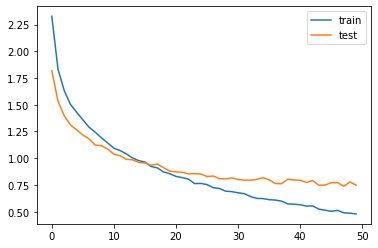

In [105]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [106]:
# evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 0.8059 - accuracy: 0.7261 - 1s/epoch - 17ms/step

Test accuracy: 0.726071298122406


In [110]:
model_cnn.save("Music_Genre_10_CNN")
model_cnn.save("Music_Genre_10_CNN.h5")

In [109]:
# Se puede usar para reconstruir el modelo de manera idéntica.
reconstructed_model = keras.models.load_model("Music_Genre_10_CNN.h5")

Ahora veamos que el epoch que es el numero de veces que se ejecutaran los algoritmos de forwardpropagation y backpropagation, no afectara en el accuracy del CNN. En cada ciclo (epoch) todos los datos de entrenamiento pasan por la red neuronal para que esta aprenda sobre ellos, si existen 10 ciclos y 1000 datos, cada ciclo los 1000 datos pasaran por la red neuronal. Esta comentado pues el tiempo que dura en realizar los epoch se demora la rededor de 9 minutos para los epoch de 50 y el de 100 20 minutos.

In [111]:
# Entrenar el modelo 2 con epochs = 100
# history2 = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

Epoch 1/100
188/188 [==============================] - 14s 76ms/step - loss: 0.4520 - accuracy: 0.8441 - val_loss: 0.7456 - val_accuracy: 0.7523
Epoch 2/100
188/188 [==============================] - 18s 98ms/step - loss: 0.4598 - accuracy: 0.8391 - val_loss: 0.7485 - val_accuracy: 0.7450
Epoch 3/100
188/188 [==============================] - 14s 73ms/step - loss: 0.4665 - accuracy: 0.8358 - val_loss: 0.7819 - val_accuracy: 0.7377
Epoch 4/100
188/188 [==============================] - 13s 70ms/step - loss: 0.4394 - accuracy: 0.8536 - val_loss: 0.7578 - val_accuracy: 0.7417
Epoch 5/100
188/188 [==============================] - 14s 73ms/step - loss: 0.4312 - accuracy: 0.8479 - val_loss: 0.7666 - val_accuracy: 0.7477
Epoch 6/100
188/188 [==============================] - 14s 75ms/step - loss: 0.4269 - accuracy: 0.8544 - val_loss: 0.7571 - val_accuracy: 0.7490
Epoch 7/100
188/188 [==============================] - 17s 93ms/step - loss: 0.4231 - accuracy: 0.8536 - val_loss: 0.7590 - val_ac

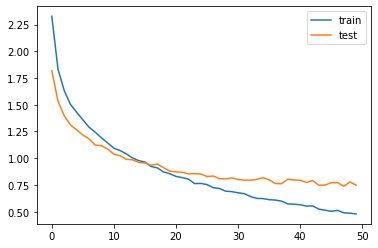

In [122]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [118]:
# evaluar el modelo en el conjunto de prueba
test_loss2, test_acc2 = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc2)

79/79 - 1s - loss: 1.0833 - accuracy: 0.7261 - 1s/epoch - 16ms/step

Test accuracy: 0.726071298122406


Asi que los tenemos ya guardados en los archivos entrenados listos para utilizarse "Music_Genre_10_2_CNN" y "Music_Genre_10_CNN"


In [119]:
model_cnn.save("Music_Genre_10_2_CNN")
model_cnn.save("Music_Genre_10_2_CNN.h5")

In [120]:
# Se puede usar para reconstruir el modelo de manera idéntica.
reconstructed_model = keras.models.load_model("Music_Genre_10_2_CNN.h5")

## Prediction on Youtube Songs

Veamos unos ejemplos con canciones sacadas de youtube en su version mp3.

In [123]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [124]:
genre_dict = {0:"blues",1:"clasical",2:"country",3:"disco",4:"hiphop",5:"metal",6:"pop",7:"reggae",8:"rock",9:"jazz"}

In [141]:
new_input_mfcc = process_input("/content/Highway to Hell.mp3", 30)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [137]:
type(new_input_mfcc)

numpy.ndarray

In [138]:
new_input_mfcc.shape

(130, 13)

In [139]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [140]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 21ms/step
Predicted Genre: rock
